In [36]:
import helpful_methods as hm
import sqlalchemy
import pandas as pd
from pathlib import Path
import talib
# from ipywidgets import widgets
import ipywidgets as widgets

import mplfinance as mpf
from patterns import patterns


In [37]:
engine = sqlalchemy.create_engine(hm.database_connection_string)
inspector = sqlalchemy.inspect(engine)
# print(engine)
db_table_names = inspector.get_table_names()
print(db_table_names)


['Billy_Portfolio_0', 'Remy_Portfolio_0']


In [38]:
portfolio_list = []
for table in db_table_names:
    portfolio_list.append(hm.gen_df(table, engine))

# print(portfolio_list)

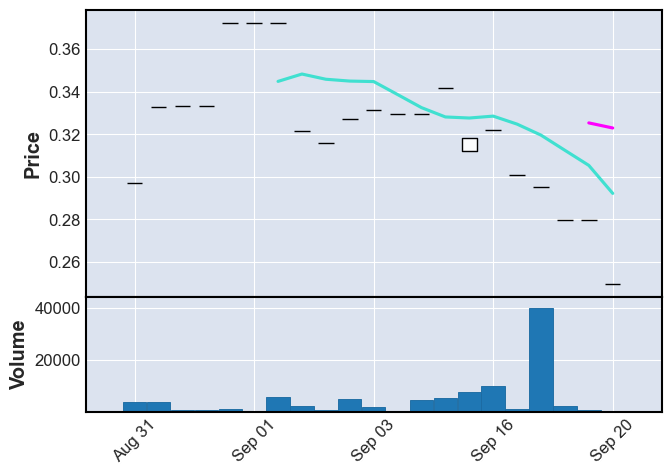

In [39]:
plot_slice = portfolio_list[0].iloc[-300:]
candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    plot_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


In [40]:
df = portfolio_list[0]
pattern_list = []

for pattern, p_name in patterns.items():
    pattern_list.append(pattern)
# print(pattern_list)
print(df.head())
print(df.tail())

                      Close    High     Low    Open Status  Volume
Time                                                              
2021-08-31 14:07:00  0.2973  0.2973  0.2973  0.2973     ok    4000
2021-09-01 10:39:00  0.3328  0.3328  0.3328  0.3328     ok    4000
2021-09-01 12:31:00  0.3333  0.3333  0.3333  0.3333     ok    1000
2021-09-01 12:32:00  0.3332  0.3332  0.3332  0.3332     ok    1000
2021-09-01 14:46:00  0.3724  0.3724  0.3724  0.3724     ok    1500
                       Close     High      Low     Open Status  Volume
Time                                                                  
2021-09-16 14:22:00  0.30095  0.30095  0.30095  0.30095     ok    1375
2021-09-17 14:22:00  0.29540  0.29540  0.29540  0.29540     ok   40000
2021-09-20 09:56:00  0.27980  0.27980  0.27980  0.27980     ok    2500
2021-09-20 13:16:00  0.27980  0.27980  0.27980  0.27980     ok    1000
2021-09-20 13:44:00  0.24960  0.24960  0.24960  0.24960     ok     500


In [41]:
candle_col_list = ['Open', 'High', 'Low', 'Close', 'Volume']


In [42]:
df_all_signals = pd.DataFrame()
# df_all_signals['Signal'] = 0.0
pattern_count_dict = {}
for pattern in pattern_list:
    pattern_count_dict[pattern] = {}
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df_all_signals[pattern] = result
        # df_all_signals['Signal'] = df_all_signals['Signal'] + result
        last = result.tail(1).values[0]
        if last > 0:
            print(f'Bullish {pattern}')
        elif last < 0:
            print(f'Bearish {pattern}')
        else:
            pass
            # print(f'None  {pattern}')
    except:
        pass
    else:
        # print(f"{pattern}\n{result.value_counts()}")
        v = result.value_counts()
        # print(v.index[0])
        # print(type(v))
        # print(pattern)
        for i, value in enumerate(v):
            pattern_count_dict[pattern][str(v.index[i])] = value
            # print(v.index[i], value)

# print(df_all_signals.tail())
# print(pattern_count_dict)

pattern_df = pd.DataFrame(pattern_count_dict).T.fillna(0)
pattern_df.drop(columns='0', inplace=True)

# print(df['Signal'].value_counts())


Bullish CDLDOJI


In [43]:
pattern_df.columns

Index(['100', '-100'], dtype='object')

In [44]:
pattern_df['sum'] = pattern_df.sum(axis=1)
pattern_df = pattern_df[pattern_df['sum'] != 0]
# pattern_df['-100'] = pattern_df['-100'] + pattern_df['-200'] 
# pattern_df['100'] = pattern_df['100'] + pattern_df['200'] 
# pattern_df = pattern_df.drop(columns=['sum', '-200', '200'])
# print(pattern_df)
print(len(pattern_df), 'Patterns')


4 Patterns


In [45]:
pattern_df = pattern_df.reset_index()
pattern_df['index'] = pattern_df['index'].apply(lambda x: patterns[x])
pattern_df.rename(columns={'index':'Pattern', '-100': 'Bearish Flags', '100': 'Bullish Flags'}, inplace=True)
pattern_df = pattern_df.set_index('Pattern')


In [46]:
display(pattern_df)

,Bullish Flags,Bearish Flags,sum
Pattern,,,
Doji,10.0,0.0,10.0
Doji Star,0.0,1.0,1.0
Up/Down-gap side-by-side white lines,0.0,1.0,1.0
Tristar Pattern,1.0,0.0,1.0


In [47]:
# vals = ['km', 'm', 'cm','mm']
sel = widgets.SelectMultiple(
        options=pattern_df.index,
        # options=pattern_list,
        # value=['m'],
        rows=min(25, len(pattern_list)),
        # column_stack=True,
        description='Unit:'
    )
display(sel)


SelectMultiple(description='Unit:', options=('Doji', 'Doji Star', 'Up/Down-gap side-by-side white lines', 'Tri…

In [48]:
df_user = pd.DataFrame()
for pattern in list(sel.value):
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df_user[pattern] = result

        # print(result)
        last = result.tail(1).values[0]
        if last > 0:
            print(f'Bullish {pattern}')
            # df[symbol][pattern] = 'bullish'
        elif last < 0:
            print(f'Bearish {pattern}')
            # df[symbol][pattern] = 'bearish'
        else:
            pass
            # print(f'None  {pattern}')
            # df[symbol][pattern] = None
        
    except:
        pass
    else:
        print(f"{pattern}\n{result.value_counts()}")

# print(df_user.tail())


In [49]:
# bear_signals_df = df.loc[df['Signal'] == df['Signal'].max(), :]
# bear_signals_df['Signal'] = 1
# bull_signals_df = df.loc[df['Signal'] == df['Signal'].max(), :]
# bull_signals_df['Signal'] = -1

# signals_df = pd.concat([bull_signals_df, bear_signals_df], axis=0)
# # print(signals_df)
# print(df.head())

In [50]:
print(df.head())

                      Close    High     Low    Open Status  Volume
Time                                                              
2021-08-31 14:07:00  0.2973  0.2973  0.2973  0.2973     ok    4000
2021-09-01 10:39:00  0.3328  0.3328  0.3328  0.3328     ok    4000
2021-09-01 12:31:00  0.3333  0.3333  0.3333  0.3333     ok    1000
2021-09-01 12:32:00  0.3332  0.3332  0.3332  0.3332     ok    1000
2021-09-01 14:46:00  0.3724  0.3724  0.3724  0.3724     ok    1500


In [54]:
df_2 = df_all_signals
df_2['CDLDOJI'].head()
df_2 = pd.concat([df, df_2['CDLDOJI']], axis=1).drop(columns='Status')
print(df_2.head(10))
print(df_2.tail(10))

                       Close     High      Low     Open  Volume  CDLDOJI
Time                                                                    
2021-08-31 14:07:00  0.29730  0.29730  0.29730  0.29730    4000        0
2021-09-01 10:39:00  0.33280  0.33280  0.33280  0.33280    4000        0
2021-09-01 12:31:00  0.33330  0.33330  0.33330  0.33330    1000        0
2021-09-01 12:32:00  0.33320  0.33320  0.33320  0.33320    1000        0
2021-09-01 14:46:00  0.37240  0.37240  0.37240  0.37240    1500        0
2021-09-01 14:54:00  0.37240  0.37240  0.37240  0.37240     500        0
2021-09-01 14:57:00  0.37240  0.37240  0.37240  0.37240    6000        0
2021-09-02 12:22:00  0.32150  0.32150  0.32150  0.32150    2500        0
2021-09-02 12:30:00  0.31565  0.31565  0.31565  0.31565    1000        0
2021-09-03 11:33:00  0.32730  0.32730  0.32730  0.32730    5150        0
                       Close     High      Low     Open  Volume  CDLDOJI
Time                                               